In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import testing as test
import graph_visualization as gv

In [2]:

read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict

graph = sg.StackedGraph(raw_json=raw_json)

In [3]:
groups = list(graph.get_node_groups(ASAP = False))
print(test.group_validate(graph, groups))
for group in groups:
    print(group)


True
[14, 18, 16, 19]
[19, 20, 22, 23, 24, 26, 27, 29, 30, 31, 33, 35, 36, 38, 40, 41, 42, 46, 47, 43, 48, 44, 49, 45, 50, 51, 58, 53, 59, 55, 60, 56, 61, 57, 62, 63, 64, 65, 67, 69, 70, 71]
[71, 72, 73, 75, 76, 78, 79, 80, 82, 84, 85, 87, 89, 90, 94, 96, 97, 99, 100, 102, 92, 103, 104, 106, 108, 109, 110]
[110, 111, 112, 114, 115, 117, 118, 119, 121, 123, 124, 126, 128, 129, 130, 134, 135, 131, 136, 132, 137, 133, 138, 139, 146, 141, 147, 143, 148, 144, 149, 145, 150, 151, 152, 153, 155, 157, 158, 159]
[159, 160, 161, 163, 164, 166, 167, 168, 170, 172, 173, 175, 177, 178, 182, 184, 185, 187, 188, 190, 180, 191, 192, 194, 196, 197, 198]
[198, 199, 200, 202, 203, 205, 206, 207, 209, 211, 212, 214, 216, 217, 218, 222, 223, 219, 224, 220, 225, 221, 226, 227, 234, 229, 235, 231, 236, 232, 237, 233, 238, 239, 240, 241, 243, 245, 246, 247]
[247, 248, 249, 251, 252, 254, 255, 256, 258, 260, 261, 263, 265, 266, 270, 272, 273, 275, 276, 278, 268, 279, 280, 282, 284, 285, 286]
[286, 287, 288, 29

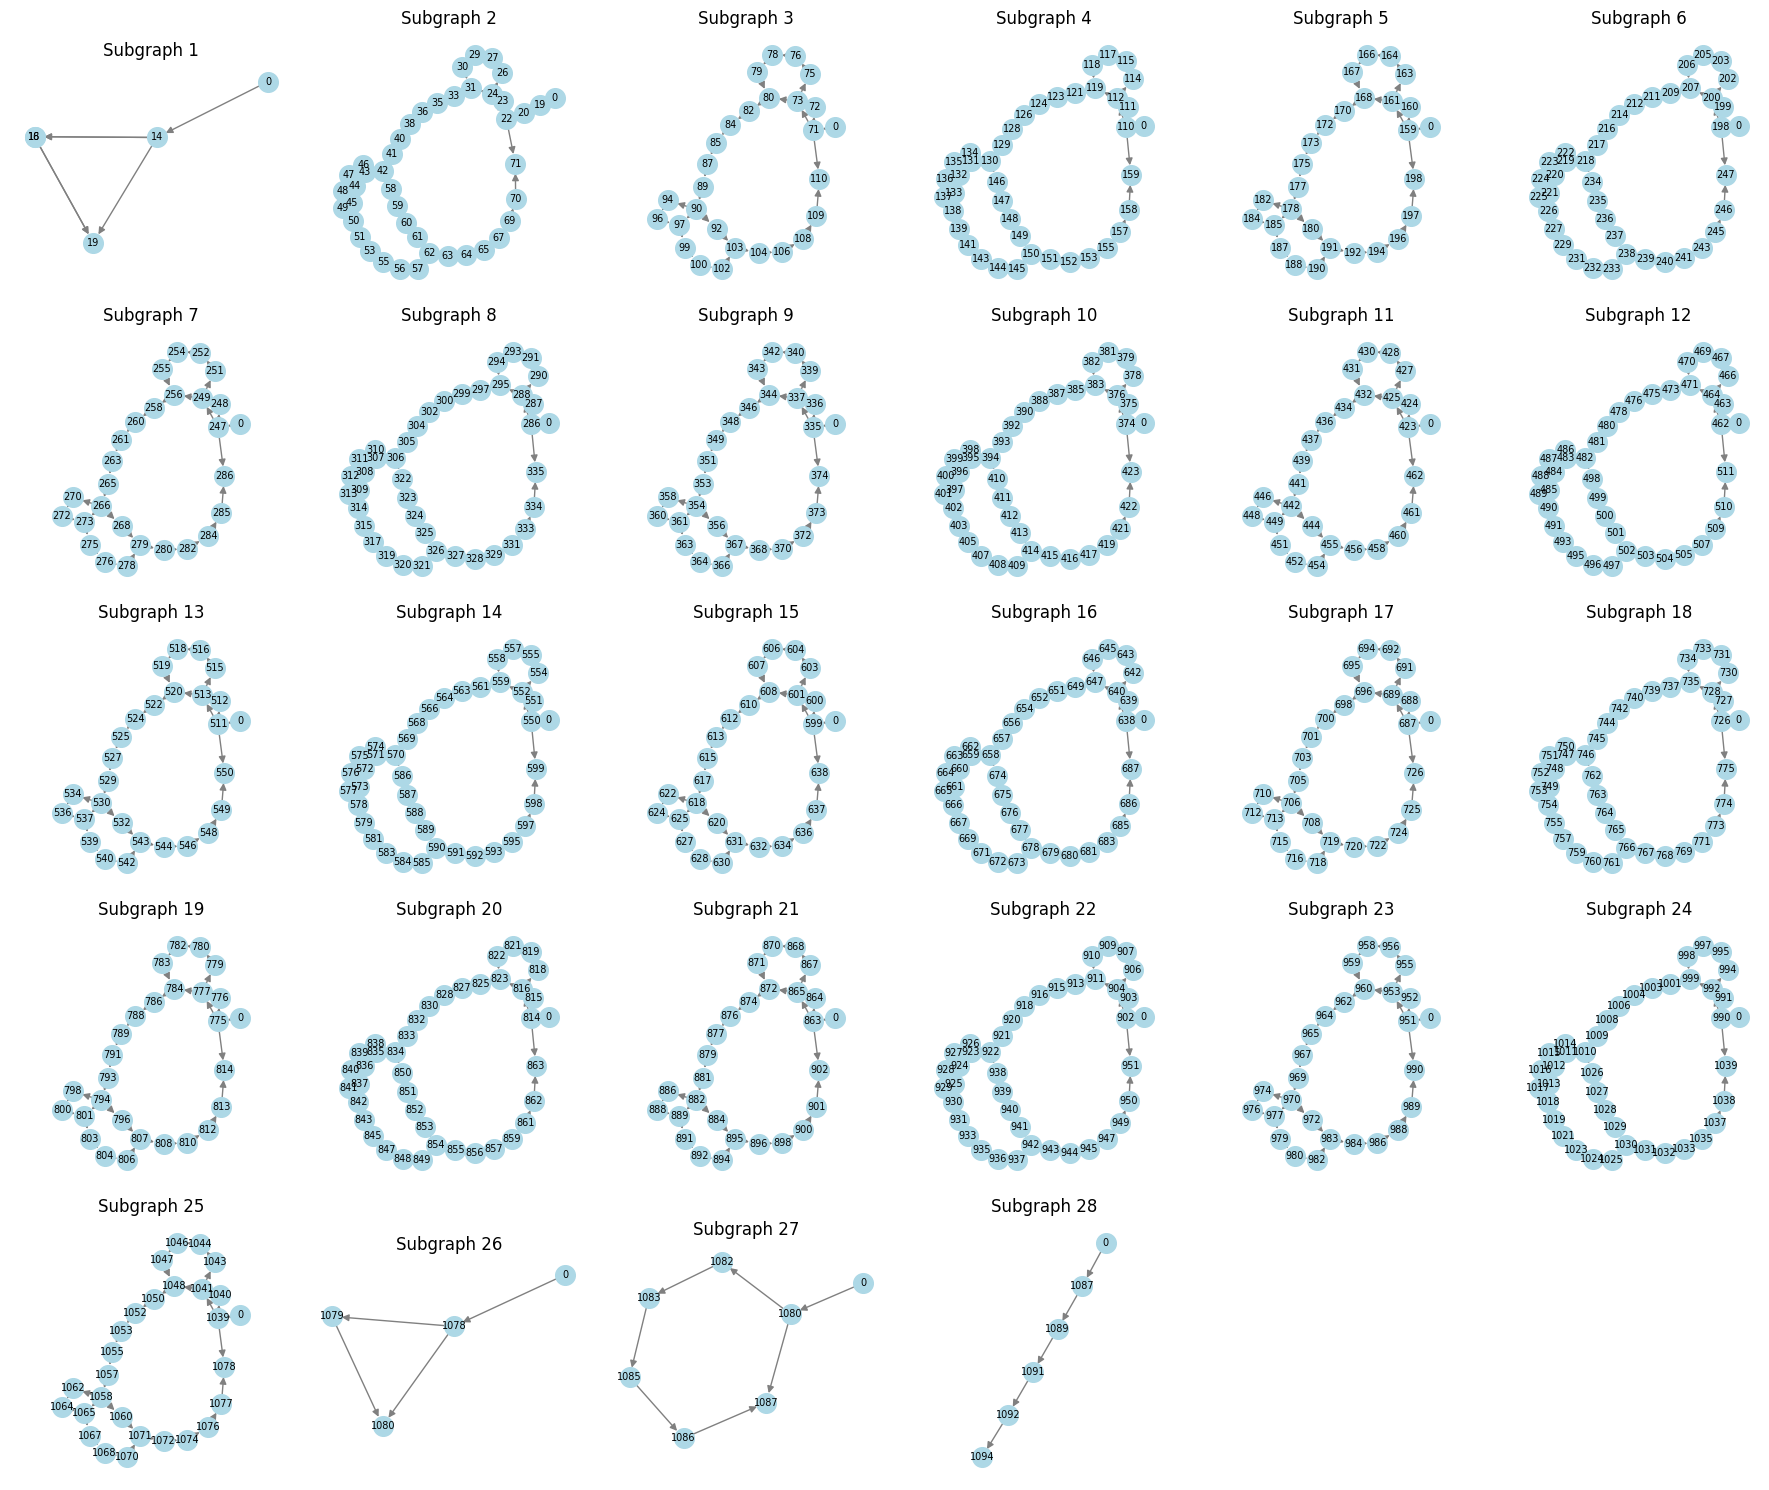

In [4]:
n_graphs = len(groups)
n_cols = 6  # Number of columns for the grid
n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axes = axes.flatten()  # Flatten the array of axes


for i in range(len(groups)):
    if i >= 0:
        test_group = groups[i]

        start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
        first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
        first_stack.parents = [0]

        subgraph_stack_list = [start_stack, first_stack]
        for stack_id in test_group[1:]:
            stack = graph.stack_list[graph.id_to_idx[stack_id]]
            new_node = copy.deepcopy(stack)
            new_node.parents = set(new_node.parents) - graph.load_nodes
            subgraph_stack_list.append(new_node)


        new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
        # gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')
        # gv.adj_to_graph(new_graph, save=False, layout = 'kk', title = f'Subgraph {i}')
        gv.adj_to_graph(new_graph, ax=axes[i], layout='kk', title=f'Subgraph {i+1}')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()
